# Check that extend fill into cavities actually worked

In [27]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cmocean
import tqdm
import cartopy.crs as ccrs
import sys
import numpy.ma as ma
sys.path.append('/home/users/birgal/')
# from nemo_python.interpolation import interp_latlon_cf, neighbours, neighbours_z, extend_into_mask

Load files

In [27]:
domcfg_new = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/domain_cfg-20231025.nc')#.isel(x=slice(350,500), y=slice(120,200))
mask_new   = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/mesh_mask-20231025.nc')#.isel(x=slice(350,500), y=slice(120,200))
IC_S       = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-SALT-initial-conditions.nc') #.isel(x=slice(350,500), y=slice(120,200))
IC_start   = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/temp/SOSE-SALT-vertical-interp.nc')#.isel(x=slice(350,500), y=slice(120,200))

In [28]:
ds = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/domcfg_eORCA025_v3.nc')
domcfg_old = xr.open_dataset(f'/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/domain_cfg-old.nc').isel(time_counter=0)
domcfg_new = xr.open_dataset(f'/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/domain_cfg-20231025.nc').isel(time_counter=0, y=slice(0,439))

In [3]:
# Finds the value of the given array to the west, east, south, north of every point, as well as which neighbours are non-missing, and how many neighbours are non-missing.
def neighbours (data, missing_val=-9999):

    # Find the value to the west, east, south, north of every point
    # Just copy the boundaries
    data_w          = np.empty(data.shape)
    data_w[...,1:]  = data[...,:-1]
    data_w[...,0]   = data[...,0]
    data_e          = np.empty(data.shape)
    data_e[...,:-1] = data[...,1:]
    data_e[...,-1]  = data[...,-1]
    
    data_s            = np.empty(data.shape)
    data_s[...,1:,:]  = data[...,:-1,:]
    data_s[...,0,:]   = data[...,0,:]
    data_n            = np.empty(data.shape)
    data_n[...,:-1,:] = data[...,1:,:]
    data_n[...,-1,:]  = data[...,-1,:]     
        
    # Arrays of 1s and 0s indicating whether these neighbours are non-missing
    valid_w = ((data_w != missing_val)*~np.isnan(data_w)).astype(float)
    valid_e = ((data_e != missing_val)*~np.isnan(data_e)).astype(float)
    valid_s = ((data_s != missing_val)*~np.isnan(data_s)).astype(float)
    valid_n = ((data_n != missing_val)*~np.isnan(data_n)).astype(float)
    data_w[np.isnan(data_w)] = 10000 # because 0*NaN = NaN
    data_e[np.isnan(data_e)] = 10000
    data_s[np.isnan(data_s)] = 10000
    data_n[np.isnan(data_n)] = 10000
    
    num_valid_neighbours = valid_w + valid_e + valid_s + valid_n
    
    return data_w, data_e, data_s, data_n, valid_w, valid_e, valid_s, valid_n, num_valid_neighbours

In [4]:
# Like the neighbours function, but in the vertical dimension: neighbours above and below
def neighbours_z (data, missing_val=-9999):

    data_u              = np.empty(data.shape)
    data_u[...,1:,:,:]  = data[...,:-1,:,:]
    data_u[...,0,:,:]   = data[...,0,:,:]
    
    data_d              = np.empty(data.shape)
    data_d[...,:-1,:,:] = data[...,1:,:,:]
    data_d[...,-1,:,:]  = data[...,-1,:,:]
    valid_u = ((data_u  != missing_val)*~np.isnan(data_u)).astype(float)
    valid_d = ((data_d  != missing_val)*~np.isnan(data_d)).astype(float)
    data_d[np.isnan(data_d)] = 10000 # because 0*NaN = NaN
    data_u[np.isnan(data_u)] = 10000
    
    num_valid_neighbours_z = valid_u + valid_d
    
    return data_u, data_d, valid_u, valid_d, num_valid_neighbours_z

In [5]:
def extend_into_mask (data, missing_val=-9999, masked=False, use_1d=False, use_2d=False, use_3d=False, preference='horizontal', num_iters=100):

    if masked:
        # MaskedArrays will mess up the extending
        # Unmask the array and fill the mask with missing values
        data_unmasked = data.data
        data_unmasked[data.mask] = missing_val
        data = data_unmasked

    for iter in tqdm.tqdm(range(num_iters)):
        if np.sum(data==missing_val) == 0: # stop looping if all missing values have been filled
            break
        else:
            # Find the neighbours of each point, whether or not they are missing, and how many non-missing neighbours there are.
            # Then choose the points that can be filled.
            # Then set them to the average of their non-missing neighbours.
            # Consider horizontal neighbours in both directions
            data_w, data_e, data_s, data_n, valid_w, valid_e, valid_s, valid_n, num_valid_neighbours = neighbours(data, missing_val=missing_val)
            index = (data == missing_val)*(num_valid_neighbours > 0)
            data[index] = (data_w[index]*valid_w[index] + data_e[index]*valid_e[index] + data_s[index]*valid_s[index] + data_n[index]*valid_n[index])/num_valid_neighbours[index]
    
            if use_3d:
                # Look for vertical neighbours
                data_d, data_u, valid_d, valid_u, num_valid_neighbours_new = neighbours_z(data, missing_val=missing_val)
                index = (data == missing_val)*(num_valid_neighbours == 0)*(num_valid_neighbours_new > 0)            
                data[index] = (data_u[index]*valid_u[index] + data_d[index]*valid_d[index])/num_valid_neighbours_new[index]
            
    if masked:
        # Remask the MaskedArray
        data = ma.masked_where(data==missing_val, data)

    return data   

In [6]:
missing     = xr.where((mask_new.tmask.isel(time_counter=0)==1).values * (np.isnan(IC_start['SALT'].values)), 1, 0)
src_to_fill = xr.where(missing==1, -9999, IC_start['SALT'].values) 

var_filled = extend_into_mask(src_to_fill, use_2d=False, use_3d=True, masked=False, num_iters=100)

# remove any points where I give a real value that are actually in the land
var_filled_plot = xr.where(mask_new.tmask.isel(time_counter=0, nav_lev=0)==0, np.nan, var_filled[0,:,:])

 75%|███████▌  | 75/100 [00:08<00:02,  8.53it/s]


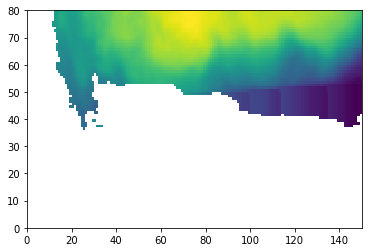

In [7]:
plt.pcolormesh(var_filled_plot)

In [10]:
not_filled = xr.where((mask_new.tmask.isel(time_counter=0)==1) * (np.isnan(IC_start['SALT'].values)), 1, 0)
srctofill  = xr.where(not_filled==1, 1000, IC_start['SALT'].values).isel(x=120)
masked_nan = xr.where(np.isnan(srctofill), 10, np.nan)
masked_fill = xr.where(np.isnan(var_filled[:,:,120]), 10, np.nan)
depth_ind = np.arange(len(srctofill.nav_lev))

(0.0, 80.0)

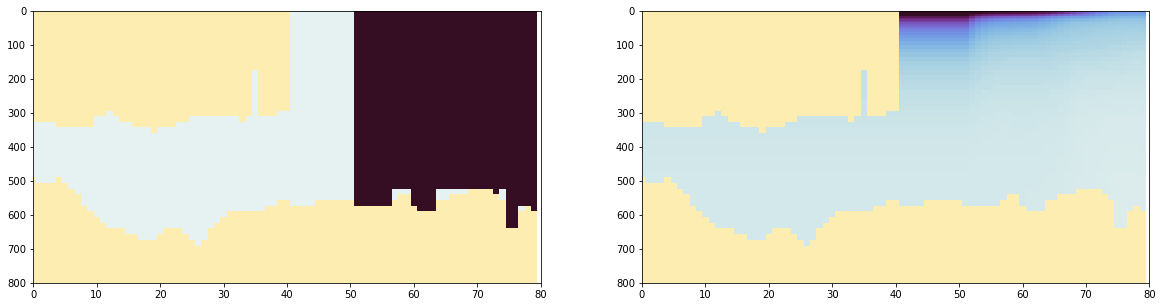

In [12]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
ax[0].pcolormesh(srctofill.y, srctofill.nav_lev, srctofill, cmap=cmocean.cm.dense_r)
ax[0].pcolormesh(srctofill.y, srctofill.nav_lev, masked_nan, cmap=cmocean.cm.matter)
# ax[0].plot([srctofill.y[41], srctofill.y[41]], [srctofill.nav_lev[0], srctofill.nav_lev[40]], '--r', linewidth=0.8)
# ax[0].pcolormesh(data_unmasked[:,:,120])
ax[0].set_ylim(800,0); ax[0].set_xlim(0,80)


ax[1].pcolormesh(srctofill.y, srctofill.nav_lev, var_filled[:,:,120], vmin=32, vmax=35, cmap=cmocean.cm.dense_r)
ax[1].pcolormesh(srctofill.y, srctofill.nav_lev, masked_fill, cmap=cmocean.cm.matter_r)
ax[1].pcolormesh(srctofill.y, srctofill.nav_lev, masked_nan, cmap=cmocean.cm.matter)
# ax[1].scatter([39, 40, 41, 42, 43], [25,25,25,25,25], c='r')
# ax[1].plot([srctofill.y[41], srctofill.y[41]], [depth_ind[28], depth_ind[58]], '--r', linewidth=0.8)
ax[1].set_ylim(800,0); ax[1].set_xlim(0,80)